In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import theano
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt

import corner


In [2]:
import xoflares #  the flares code

In [3]:
print(xo.__version__)
print(theano.__version__)
print(pm.__version__)

0.2.4.dev69+gc063778
1.0.4
3.7


In [4]:
#  let's create some take data
#  we simulate n flares. In reality the flares enengies are distributed like a power law,
#  but that's not easy to draw from here, so we'll make the amplitudes follow a power law.
#  Inside the model, we learn the shape of the power law, in the real stars example, we want to
#  learn that function of ED, not amplitude.
t = np.arange(0, 25, 2/1440)
npeaks = 2
np.random.seed(8675309)
tpeaks = np.random.choice(t, size=npeaks)
fwhms = np.random.uniform(size=npeaks, low=6/1440, high=60/1440)

a = 2
mconst = 2
ampls = pm.distributions.continuous.Pareto.dist(a, mconst).random(size=npeaks)
# lam = 2
# ampls = lam * np.exp(-np.random.uniform(size=npeaks) * lam)


# ampls = np.random.pareto(a=1.8, size=20)

In [5]:
data_len = t.shape[0]

In [6]:
y = xoflares.eval_get_light_curve(t, tpeaks, fwhms ,ampls)
y_orig = np.copy(y)
yerr = 0.1 * np.ones_like(y)
y +=  np.random.normal(scale=yerr, size=np.shape(t)[0])
x = np.copy(t)

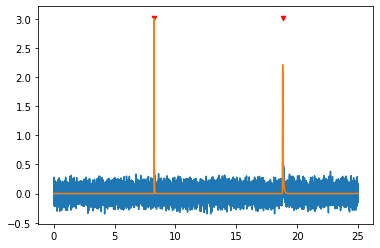

In [7]:
plt.plot(t, y)
plt.plot(t, xoflares.eval_get_light_curve(t, tpeaks, fwhms ,ampls))
plt.scatter(tpeaks, np.zeros_like(tpeaks) + np.max(ampls), color='r', s=20, marker='v')

In [8]:
tpeaks_d = np.copy(tpeaks)
fwhms_d = np.copy(fwhms)
ampls_d = np.copy(ampls)
def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones_like(x, dtype=bool)
    with pm.Model() as model:

        BoundedNormal = pm.Bound(pm.Normal, lower=0)
        xval = pm.Data('xval', x[mask])
        data = pm.Data('data', y[mask])
        data_err = pm.Data('data_err', yerr[mask])

        # The mean flux of the time series
        mean = pm.Normal("mean", mu=0, sd=2.0)

#        prior on the flare energies, loglike of pareto dist
        logalpha = pm.Normal('logalpha', mu=np.log(a), sd=1, testval=np.log(a))
        alpha = pm.Deterministic('alpha', tt.exp(logalpha))
        
        m = BoundedNormal('m', mu=mconst, sd=1, testval=mconst)
        ampl = pm.Pareto('ampl', alpha=alpha, m=m, shape=npeaks, testval=ampls_d)
        
        tpeak = BoundedNormal("tpeak", mu=tpeaks_d, sd=0.003,
                      testval=tpeaks, shape=npeaks)
        logFwhm = pm.Normal("logFwhm", mu=tt.log(fwhms_d), sd=0.1, testval=tt.log(fwhms_d),
                        shape=npeaks)
        fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
     
        light_curve = xoflares.get_light_curve(xval, tpeak, fwhm, ampl, oversample=7, texp=None)

        pm.Deterministic("light_curve", light_curve)
        model.light_curves = light_curve

        pm.Normal('obs', mu=light_curve + mean, sd=data_err, observed=data,
                 total_size=data_len)

        ED_days = xoflares.multiflareintegral(fwhm, ampl)
        pm.Deterministic("ED_days", ED_days)
    
        # Optimize to find the maximum a posteriori parameters
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[mean])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, mean])
        map_soln = xo.optimize(start=map_soln, vars=[ampl, mean])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, ampl])
        map_soln = xo.optimize(start=map_soln, vars=[tpeak])

        map_soln = xo.optimize(start=map_soln, vars=[mean])
        map_soln = xo.optimize(start=map_soln, vars=[logalpha, m])


#         map_soln = xo.optimize(start=map_soln, vars=[fwhm, mean])
#         map_soln = xo.optimize(start=map_soln, vars=[ampl, mean])
#         map_soln = xo.optimize(start=map_soln, vars=[fwhm, ampl])
#         map_soln = xo.optimize(start=map_soln, vars=[tpeak])
#         map_soln = xo.optimize(start=map_soln, vars=[tpeak,fwhm, ampl])
    return model, map_soln

model0, map_soln0 = build_model()
print(model0.check_test_point())

optimizing logp for variables: [mean]
5it [00:01,  3.46it/s, logp=1.590808e+04]  
message: Optimization terminated successfully.
logp: 15900.7606322508 -> 15908.079702058018
optimizing logp for variables: [mean, logFwhm]
12it [00:00, 20.68it/s, logp=1.591031e+04] 
message: Optimization terminated successfully.
logp: 15908.079702058018 -> 15910.31406328817
optimizing logp for variables: [mean, ampl, m]
86it [00:00, 121.72it/s, logp=1.591160e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: 15910.31406328817 -> 15911.60143863722
optimizing logp for variables: [ampl, m, logFwhm]
19it [00:00, 33.42it/s, logp=1.591259e+04] 
message: Optimization terminated successfully.
logp: 15911.60143863722 -> 15912.591487351308
optimizing logp for variables: [tpeak]
14it [00:00, 14.88it/s, logp=1.591352e+04] 
message: Optimization terminated successfully.
logp: 15912.591487351308 -> 15913.516936364891
optimizing logp for variables: [mean]
5it [00:00,  8.44it/s, logp=1.591

mean                     -1.61
logalpha                 -0.92
m_lowerbound__           -0.23
ampl_lowerbound__        -3.07
tpeak_lowerbound__       14.82
logFwhm                   2.77
obs                   15889.00
Name: Log-probability of test_point, dtype: float64


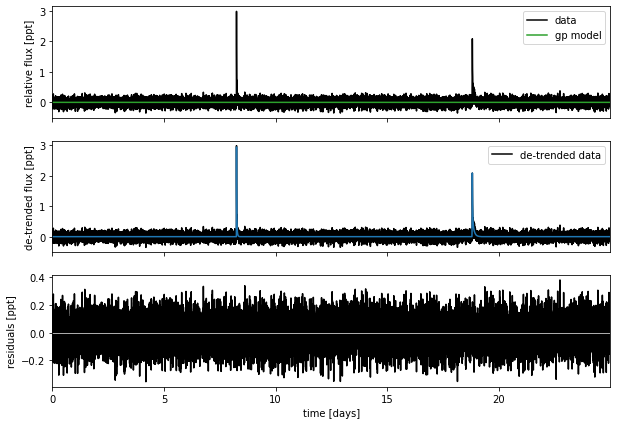

In [9]:
def plot_light_curve(model, soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = np.ones_like(x[mask]) * soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    light_curve = xo.utils.eval_in_model(model.light_curves, soln, model=model)

    mod = light_curve
    ax.plot(x[mask], mod,)
    ax.legend(fontsize=10)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + light_curve
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(model0, map_soln0);

optimizing logp for variables: [mean]
5it [00:00,  9.23it/s, logp=1.591358e+04]  
message: Optimization terminated successfully.
logp: 15913.580227207049 -> 15913.580298373003
optimizing logp for variables: [mean, logFwhm]
82it [00:01, 75.48it/s, logp=1.591363e+04] 
message: Desired error not necessarily achieved due to precision loss.
logp: 15913.580298373003 -> 15913.633147736437
optimizing logp for variables: [mean, ampl, m]
57it [00:01, 49.46it/s, logp=1.591368e+04] 
message: Optimization terminated successfully.
logp: 15913.633147736437 -> 15913.675595721208
optimizing logp for variables: [ampl, m, logFwhm]
55it [00:00, 84.10it/s, logp=1.591371e+04] 
message: Desired error not necessarily achieved due to precision loss.
logp: 15913.675595721208 -> 15913.708157539737
optimizing logp for variables: [tpeak]
92it [00:00, 124.63it/s, logp=1.591372e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: 15913.708157539737 -> 15913.719229710145
optimizing logp f

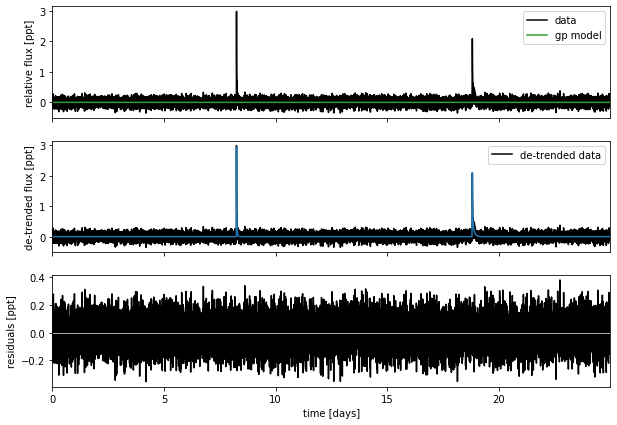

In [10]:
model, map_soln1 = build_model(mask=None, start=map_soln0)
fig = plot_light_curve(model, map_soln1, mask=None)

In [11]:
with model:
    map_soln2 = xo.optimize(start=map_soln1,)

optimizing logp for variables: [logFwhm, tpeak, ampl, m, logalpha, mean]
90it [00:00, 436.53it/s, logp=1.591372e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: 15913.722823556407 -> 15913.723939306024


In [12]:
with model:

    trace = pm.sample(tune=1500, draws=1000, start=map_soln2, chains=4,
                      step=xo.get_dense_nuts_step(target_accept=0.9, doubling=True, adaptation_window=101),
                     )

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logFwhm, tpeak, ampl, m, logalpha, mean]
Sampling 4 chains: 100%|██████████| 10000/10000 [04:44<00:00, 35.14draws/s]
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8383804976430879, but should be close to 0.9. Try to increase the number of tuning steps.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


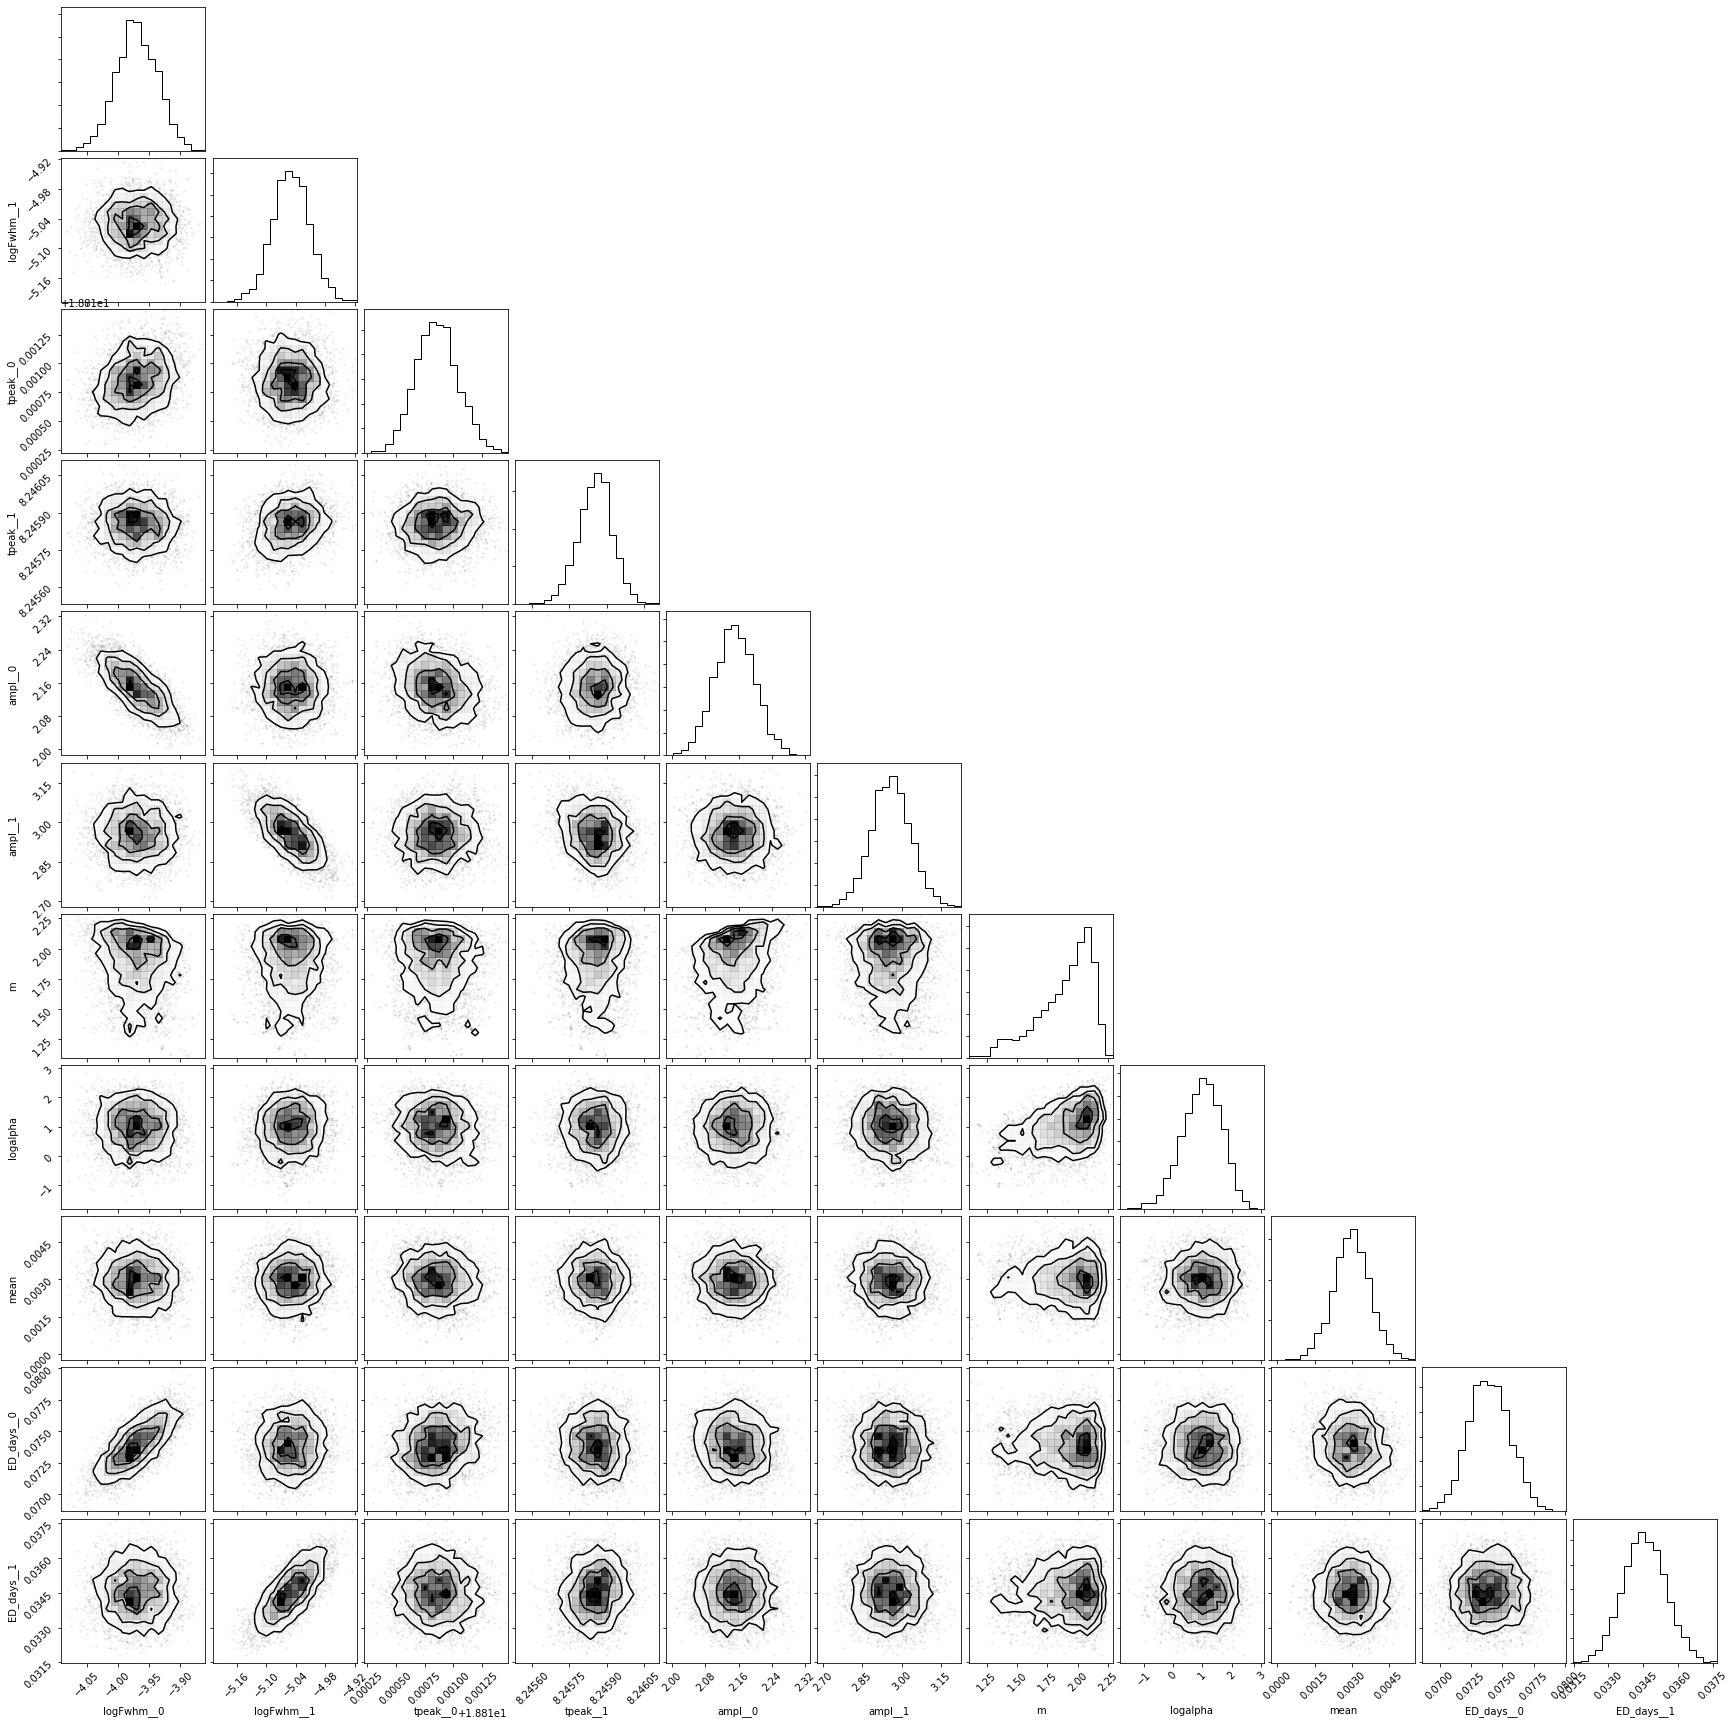

In [13]:
samples = pm.trace_to_dataframe(trace, varnames=["logFwhm", "tpeak", "ampl", "m", "logalpha", "mean", "ED_days"])

_ = corner.corner(samples)

In [14]:
# plt.hist(map_soln2['ampl'], bins=10, normed=True)

# v = np.arange(2,150,0.1)
# a1 = map_soln2['alpha']
# m1 = map_soln2['m']
# # lam1 = map_soln2['lamval']
# plt.plot(v, (a1 * m1**a1) / (v**(a1+1)))

# plt.ylabel('frequency')
# plt.xlabel('flare energy')

array([93.14801203,  2.30182029, 44.5220584 ])